# Assignment 3
`Yosemite Village Yearly Weather` | `RBFs` | `Ridge Regression` 

## Starting Prompt
Temperature is cyclical, not only on a 24 hour basis but also on a yearly basis. Convert the dataset into a richer format whereby the day of the year is also captured. For example the time “20150212 1605”, can be converted into (43, 965) because the 12th of February is the 43rd day of the year, and 16:05 is the 965th minute of the day.

This data covers 6 years, so split the data into a training set of the first 5 years, and a testing set of the 6th year.

### 1. Library Importation

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

#Import packages for RBF transformation and pipeline setup
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.linear_model import Ridge
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

#Import packages for BayesSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer

#Had to downgrade packages to get BayesSearchCV to work
#!pip install scikit-learn==0.23.2
#!pip install scipy==1.5.3

### 2. Loading the data

In [4]:
#Specify the data files and columns to load
years = range(2011, 2017)
files = ['data/CRNS0101-05-%d-CA_Yosemite_Village_12_W.txt' % y for y in years]
usecols = [1, 2, 8]

#Load the data and open as a pandas dataframe
data = [np.loadtxt(f, usecols=usecols) for f in files]
data = pd.DataFrame(np.vstack(data), columns = ["Date", "Time", "Temperature"])
data.head()

,Date,Time,Temperature
0,20110101.0,5.0,-6.4
1,20110101.0,10.0,-6.5
2,20110101.0,15.0,-6.5
3,20110101.0,20.0,-6.5
4,20110101.0,25.0,-6.7


### 3. Data cleaning and reformatting

**Remove invalid temperature datapoints**

In [5]:
orig_size = len(data)
data = data[data["Temperature"] > -1000] #Remove temperature values less than -1000
new_size = len(data)

print(f"{orig_size-new_size} removed from the dataset. Size dropped from {orig_size} to {new_size}")

442 removed from the dataset. Size dropped from 631296 to 630854


**Define functions to transform the data**

In [6]:
#Function to convert time from Hh:mm to mins (where mins is the nth minute of the day)
Hmm_to_mins = lambda x: np.floor_divide(int(x),100)*60 + np.mod(int(x),100)

#Function to get the day of the year from a datetime object
get_day_of_year = lambda date: date.timetuple().tm_yday

**Transform the data**

In [7]:
#Convert Time to the minute of the day
data.Time = data.Time.apply(Hmm_to_mins)

#Convert Date to Y-m-d format
data.Date = pd.to_datetime(data.Date, format = '%Y%m%d')

#Get the day of the year from Date
data['DOY'] = data.Date.apply(get_day_of_year)

data.head()

,Date,Time,Temperature,DOY
0,2011-01-01,5,-6.4,1
1,2011-01-01,10,-6.5,1
2,2011-01-01,15,-6.5,1
3,2011-01-01,20,-6.5,1
4,2011-01-01,25,-6.7,1


### 4. Split to training and test set

In [8]:
#Training set: years before 2016 
train_data = data[data.Date < datetime(2016,1,1)]  

#Test set: 2016 and later 
test_data = data[data.Date >= datetime(2016,1,1)]  

X_train, y_train = np.array([*zip(train_data.DOY,train_data.Time)]), train_data.Temperature.values
X_test, y_test = np.array([*zip(test_data.DOY,test_data.Time)]), test_data.Temperature.values

---

## Task 1

Cover each input dimension with a list of radial basis functions. This turns the pair of inputs into a much richer representation, mapping $(d,t)$ into $(Φ₁(d), Φ₂(t))$. Experiment with different numbers of radial basis functions and different widths of the radial basis function in different dimensions. Using this new representation, build a linear parameter model that captures both seasonal variations and daily variations.

**`RBF Transformation Discussion`**

Evident from the prompt above, there are various parameters that can be tuned (e.g. number of RBFs, sigma for the RBF, alpha for the ridge regression, etc.) to (hopefully) get us a high an 𝑅² value as possible. Given there are infinitely many combinations of values and different directions we can tune the parameters in, a trial and error approach to this problem could be cumbersome. 

Naturally, I cast my thoughts to a parameter search and optimization strategy such as sklearn's GridSearch CV or a Bayesian optimization over hyper parameters (possible with skopt's BayesSearchCV) as a potential strategy to determine the optimal parameter configurations.

However, to utilize a lot of these optimization functions, an estimator with a fit, score, and transform method has to to be inputted (see [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) and [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html)). Hence I build an estimator with these attributes using sci-kit learn's PCA documentation (see [here](https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/decomposition/_pca.py#L116) and [here](https://github.com/scikit-learn/scikit-learn/blob/0d378913be6d7e485b792ea36e9268be31ed52d0/sklearn/decomposition/_base.py#L19)) as guidance. I specifically looked towards PCA( ) because our goal is to carry out a transformation of the input data into an RBF representation and this bears similarity to PCA as PCA transforms data to a lower-dimensional representation

In [57]:
class RBF_generator(TransformerMixin, BaseEstimator):
    
    """
    Transform input into richer RBF representation
    
    Inputs:
        - Xx_range_min (int): The smallest value in the input dimension
        - Xx_range_max (int): The largest value in the input dimension
        - Xx_num_of_centers (int): The number of RBF centers to compute for a given input dimension Xx
        - sigma (float): Influences RBF gamma, which influences the width of the RBF.
                         The higher sigma, the wider the RBF
                                
    
    Created by consulting sklearn's PCA documentation:
    - https://github.com/scikit-learn/scikit-learn/blob/0d378913b/sklearn/decomposition/_pca.py#L116
    - https://github.com/scikit-learn/scikit-learn/blob/0d378913be6d7e485b792ea36e9268be31ed52d0/sklearn/decomposition/_base.py#L19
    
    
    """
    
    def __init__(self, 
                 #Parameters for first input dimension
                 X1_range_min, X1_range_max, X1_num_of_centers=20, 
                 #Parameters for second input dimension – if present
                 X2_range_min = None, X2_range_max = None, X2_num_of_centers = None, 
                 sigma= 1000):
    
        
        #Initialize the input dimension range values
        #These will correspond to either time or day of year values or both in this scenario
        self.X1_range_min = X1_range_min
        self.X1_range_max = X1_range_max
        self.X2_range_min = X2_range_min
        self.X2_range_max = X2_range_max
        
        #Number of centers for the variables. This will affect the number of RBFs
        self.X1_num_of_centers = X1_num_of_centers
        self.X2_num_of_centers = X2_num_of_centers
        
        #Sigma which influences width of the RBF
        self.sigma = sigma
        
    
    def fit(self,X=None,y=None):
        
        """
        Determine the centers for the RBFs fitting across the input dimensions
        
        Parameters
        ----------
        X : Ignored
            Ignored.
            
        y : Ignored
            Ignored.
        
        Returns
        -------
        self : object
            Returns the instance itself.
        
        """
        
        #If two input dimensions entered – i.e. if modeling both daily and yearly component
        if self.X1_num_of_centers and self.X2_num_of_centers:
            
            #Place RBF centres evenly spaced across the range of X1
            self.centers_X1 = np.linspace(self.X1_range_min, self.X1_range_max, 
                                          self.X1_num_of_centers).reshape(-1, 1)
            
            
            #Place RBF centres evenly spaced across the range of X2
            self.centers_X2 = np.linspace(self.X2_range_min, self.X2_range_max, 
                                          self.X2_num_of_centers).reshape(-1, 1)
         
        #If just one input dimension
        else:
            #Place RBF centres evenly spaced across the range of the inputted dimension
            self.centers = np.linspace(self.X1_range_min, self.X1_range_max, 
                                          self.X1_num_of_centers).reshape(-1, 1)
            
        
        return self
        
    
    def transform(self,X):
        
        """
        Apply RBF transformation
        
        X is transformed into a richer representation of a list of radial basis functions
        
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            where `n_samples` is the number of samples
            and `n_features` is the number of features.
            
        Returns
        -------
            : list of radial basis functions
            
        """
        
        #If two input dimensions were entered i.e. if training with full model
        if self.X1_num_of_centers and self.X2_num_of_centers:
            
            #Fit RBFs on both input dimensions separately
            X1_rbf = rbf_kernel(X[:,0].reshape(-1, 1), self.centers_X1, gamma=1.0/self.sigma)
            X2_rbf = rbf_kernel(X[:,1].reshape(-1, 1), self.centers_X2, gamma=1.0/self.sigma)
            
            #Then concatenate RBF representation to form two columns
            return np.concatenate((X1_rbf,X2_rbf),axis=1)
        
        #Return single dimension RBF representation
        else:
            return rbf_kernel(X, self.centers, gamma=1.0/self.sigma)
        

The RBF_generator class at a high level transforms inputted data into an RBF representation. It achieves this through the following methods:
- **`fit`:** Takes the minimum and maximum value in the input dimension and tries to spread as many RBF centres evenly across this range as specified


- **`transform`:** If the input is 2D, we find the centres (using `fit` as described above) for each input dimension and fit an RBF on each input dimension, ultimately concatenating both the RBF representation for each input dimension. If 1D, simply utilize the centres (as determined through `fit`) to transform to an RBF representation

**`Linear Parameter Model Fitting Discussion`**

To fit a Linear Parameter Model (using the RBF representation) that maximizes 𝑅², I utilized [BayesSearchCV](https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html) to attempt to find the optimal parameters. This optimization strategy was chosen over [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) because it allows the specification of prior distribution on parameters, thus allowing me express my uncertainty as I deem fit (often through uninformative priors). GridSearchCV, on the otherhand, exhaustively searches specified parameter values (Sklearn,n.d.).

P.S. I later discovered RandomSearchCV and think this could also be a nice approach to experiment with as it conduct a randomized search over the parameter space (Sklearn,n.d.).

In the code, this the BayesSearchCV is implemented with the help of Pipeline which allows the joint RBF transformation then Ridge regression modeling

## Task 2
Using $R²$, quantify how your model performs on the testing data in the different scenarios below. Also create plots showing the contributions:

First a define a function to plot the contributions:

In [10]:
def LPM_plotting(var,x,num_of_centers, sigma,alpha):
    
    """
    Function to plot the data and the model's contribution/predictions
    
    Inputs:
        - x (list/array): The x-values representing either DOY or time of day
        - num_of_centers (int): Number of centres determined from optimization
        - sigma (float): Optimal sigma for RBF determined from optimization
        - alpha (float): Optimal alpha for ridge regression determined from optimization
        
    Output:
        - Plot of model predictions alongside true data
    
    """
    
    #Get min and max values for the input. These will be fed into the RBF function
    x_min = x.min()
    x_max = x.max()
    
    #Get the RBF representation of the input
    RBF = RBF_generator(x_min, x_max, X1_num_of_centers=num_of_centers, sigma= sigma)
    RBF.fit()
    transformed_x = RBF.transform(x)
    
    #Fit Ridge regression to training data
    regr = Ridge(alpha= alpha, fit_intercept=False).fit(transformed_x,y_train)
    
    
    #Get equally spaced points across the input dimension and transform them using the RBF
    x_pred = np.linspace(x_min, x_max, 1000).reshape(-1, 1)
    
    RBF = RBF_generator(x_pred.min(), x_pred.max(), X1_num_of_centers=num_of_centers, sigma= sigma)
    RBF.fit()
    transformed_x_pred = RBF.transform(x_pred)
    
    #Predict the value using the fitted regression
    y_pred = regr.predict(transformed_x_pred)
    
    
    plt.scatter(data[var], data.Temperature, label='Data', color='b')
    plt.plot(x_pred, y_pred, label='Linear prediction', color='r')
    plt.legend(loc='best')
    plt.show()

### a. Train with just the daily component of the model

In [71]:
#Note steps – these will be used in the creation of a pipeline
estimators = [('rbf', RBF_generator(X_train[:,1].min(), X_train[:,1].max())), 
              ('clf', Ridge(fit_intercept = False))]

#Create pipeline
pipe = Pipeline(estimators)

#Define search space
opt = BayesSearchCV(
    pipe,
    {
        'rbf__X1_num_of_centers': Integer(10,200),
        'rbf__sigma': Real(1e-6, 1e+6),
        'clf__alpha': Real(1e-6,1e+6),
    }, 
    scoring = 'r2'
)

#Execute bayesian optimization
_ = opt.fit(X_train[:,1].reshape(-1, 1), y_train.reshape(-1, 1))

In [72]:
#Get the best parameters
opt.best_params_

OrderedDict([('clf__alpha', 1e-06),
             ('rbf__X1_num_of_centers', 200),
             ('rbf__sigma', 136356.68654502626)])

#### Plot the contribution and calculate the 𝑅² values

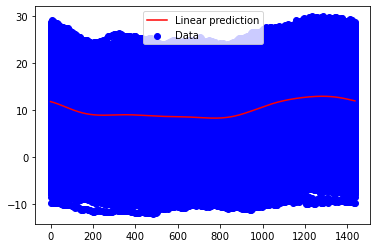

Training data 𝑅²: 0.027737129992537895
Test data 𝑅²: 0.04427342465816131


In [73]:
LPM_plotting('Time', X_train[:,1].reshape(-1, 1),
             num_of_centers = opt.best_params_['rbf__X1_num_of_centers'], 
             sigma = opt.best_params_['rbf__sigma'],
             alpha = opt.best_params_['clf__alpha'])
print(f"Training data 𝑅²: {opt.best_score_}")
print(f"Test data 𝑅²: {opt.score(X_test[:,1].reshape(-1, 1), y_test.reshape(-1, 1))}")

From the results above, we see that the BayesSearch terminated at a training data 𝑅² of 0.02 which is quite low. However, we note that the test data 𝑅² is actually larger than the training data's. This might not be suprising given the test data is much smaller than the training data and only models time values across one year – so (possibly) less variance

We also note that the optimal parameters involved fitting 200 wide (as evidenced by the high sigma – which makes gamma small) RBFs.

### b. Train with just the yearly component of the model

In [14]:
#Note steps – these will be used in the creation of a pipeline
estimators = [('rbf', RBF_generator(X_train[:,0].min(), X_train[:,0].max())), 
              ('clf', Ridge(fit_intercept = False))]

#Create pipeline
pipe = Pipeline(estimators)

#Define search space
opt = BayesSearchCV(
    pipe,
    {
        'rbf__X1_num_of_centers': Integer(10,100),
        'rbf__sigma': Real(1e-6, 1e+6),
        'clf__alpha': Real(1e-6,1e+6),
    }, 
    scoring = 'r2'
)

#Execute bayesian optimization
_ = opt.fit(X_train[:,0].reshape(-1, 1), y_train.reshape(-1, 1))

In [16]:
#Get the best parameters
opt.best_params_

OrderedDict([('clf__alpha', 1e-06),
             ('rbf__X1_num_of_centers', 12),
             ('rbf__sigma', 41358.77873982265)])

#### Plot the contribution and calculate the 𝑅² values

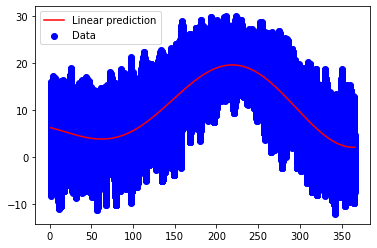

Training data 𝑅²: 0.5318687992588776
Test data 𝑅²: 0.5797047087377801


In [15]:
LPM_plotting('DOY', X_train[:,0].reshape(-1, 1),
             num_of_centers = opt.best_params_['rbf__X1_num_of_centers'], 
             sigma = opt.best_params_['rbf__sigma'],
             alpha = opt.best_params_['clf__alpha'])
print(f"Training data 𝑅²: {opt.best_score_}")
print(f"Test data 𝑅²: {opt.score(X_test[:,0].reshape(-1, 1), y_test.reshape(-1, 1))}")

Observing the 𝑅², we see that for the training set, the model explains more than 50% of the variation in the data, which is quite good. Again, we see that the test set had a higher 𝑅² value (again possibly for similar reasons – smaller sample, shorter timeframe), indicating that the model explained almost 60% of the variation in the data.

### c. Train with the full model

In [65]:
#Note steps – these will be used in the creation of a pipeline
estimators = [('rbf', 
               RBF_generator(
                   X1_range_min = X_train[:,0].min(), 
                   X1_range_max = X_train[:,0].max(), 
                   X2_range_min = X_train[:,1].min(),
                   X2_range_max = X_train[:,1].max())), 
              ('clf', Ridge(fit_intercept = False))]

#Create pipeline
pipe = Pipeline(estimators)

#Define search space
opt = BayesSearchCV(
    pipe,
    {
        'rbf__X1_num_of_centers': Integer(10,150),
        'rbf__X2_num_of_centers': Integer(10,150),
        'rbf__sigma': Real(1e-6, 1e+6),
        'clf__alpha': Real(1e-10,1e+6),
    }, 
    scoring = 'r2'
)

#Execute bayesian optimization
_ = opt.fit(X_train, y_train.reshape(-1, 1))

In [66]:
#Get the best parameters
opt.best_params_

OrderedDict([('clf__alpha', 1e-10),
             ('rbf__X1_num_of_centers', 69),
             ('rbf__X2_num_of_centers', 47),
             ('rbf__sigma', 116721.64685151148)])

In [67]:
print(f"Training data 𝑅²: {opt.best_score_}")
print(f"Test data 𝑅²: {opt.score(X_test, y_test.reshape(-1, 1))}")

Training data 𝑅²: 0.5775813735460777
Test data 𝑅²: 0.6242987992935105


To combine the time-of-day and time-of-year contributions, I concatenated the RBF representations of both dimensions and fed that into the model to predict temperature (Note, parameter values were optimized for using Bayesian optimization search). Doing so resulted in a 58% and 62% 𝑅² for the training and test sets, respectively, which is pretty good. This tells us that the model's fit accounts for about 62% of the variation in the test set. The fact that the model performed better on the test set than training set, also tells us that it generalizes pretty well. 

Another possible approach to factor in both time-of-day and time-of-year contributions could have been to find numerous centres that span the grid formed by the two input dimensions. However, I anticipated this would be computationally expensive for the BayesSearchAlgorithm as there are numerous permutations of centres that can be made, especially given I allow for different number of centres for each dimension. This doesn't even factor the optimization for other parameters such as sigma and alpha. 

In conclusion, we see that predicting with the full model improved both training and test 𝑅², compared to training with each component individually. The improved 𝑅² in the full model, per my calculation, also wasn't additive. This might suggest that interactions between both components also provides some explanatory/predictiveness power.

## HC Appendix

- **#optimization:** I implemented a Bayesian optimization over hyper parameters using skopt's BayesSearchCV to determine the optimal parameters for the RBF fitting and ridge regression. I also justified why I chose this particular optimization approach over others and additionally interpreted results from the optimization.

## References
- sklearn.model_selection.RandomizedSearchCV. (2021). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html
- sklearn.model_selection.GridSearchCV. (2021). Scikit-Learn. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
- skopt.BayesSearchCV — scikit-optimize 0.8.1 documentation. (2017). Github.io. https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html
